In [4]:
%pip install ortools matplotlib

^C


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     -------------------- ------------------- 30.7/61.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 61.0/61.0 kB 1.6 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     ------------------------------------- 165.5/165.5 kB 10.3 MB/s eta 0:00:00
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/130.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/130.2 MB 14.5 MB/s eta 0:00:09
   ---------------------------------------- 1.3/130.2 MB 16.1 MB/s eta 0:00:08
    --------------------------------------- 2.4/130.2 MB 19.4 MB/s eta 0:00:07
   - -------------------------------------- 4.2/130.2 MB 24.5 MB/s eta 0:00:06
   -- --------------------------

In [2]:
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

## Production Scheme Optimization ##


### Settings ###

- The `maxPiecesPerHarvest` is the maximum number of cuttings you can take from a plant;
- The `firstHarvestWeek` is the first harvest week after planting the cuttings;
- The `margin` is the margin between the supply and demand;
- The `minimumNumberOfPlants` and `maximumNumberOfPlants` are the minimum and maximum plants for one batch;
- The `minimumPlantweek` and `maximumPlantweek` are the minimum and maximum week in which there is demand.
- The `penalty_factor` should be large enough to prioritize reducing the number of planting jobs while still meeting demand. Adjusting this factor can help balance the trade-off between minimizing planting jobs and meeting demand.

### Input ###

- The production curve for a type of plant. The production curve is a list and has the number of `weeks` and the `growth percentage`;
- The demand is a list with `weeks` and `demand`.


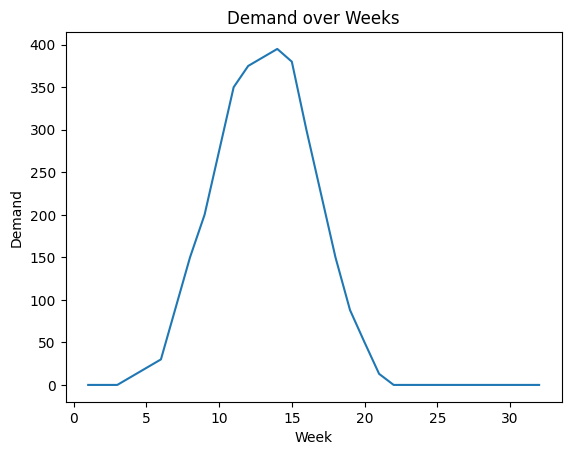

In [3]:
# Settings
maxPiecesPerHarvest = 5
firstHarvestWeek = 3
margin = 0
minimumNumberOfPlants = 0
maximumNumberOfPlants = 50
minimumPlantweek = 1
maximumPlantweek = 32
penalty_factor = 500

# Input example for one plant and demand
productionCurve = {
    1: 20,
    2: 40,
    3: 60,
    4: 80,
    5: 100,
    6: 100,
    7: 100,
    8: 100,
    9: 100,
    10: 70,
    11: 40,
    12: 10
}

demand = {
    1: 0,
    2: 0,
    3: 0,
    4: 10,
    5: 20,
    6: 30,
    7: 90,
    8: 150,
    9: 200,
    10: 275,
    11: 350,
    12: 375,
    13: 385,
    14: 395,
    15: 380,
    16: 300,
    17: 225,
    18: 150,
    19: 88,
    20: 50,
    21: 13,
    22: 0,
    23: 0,
    24: 0,
    25: 0,
    26: 0,
    27: 0,
    28: 0,
    29: 0,
    30: 0,
    31: 0,
    32: 0
}

# Plot demand
plt.plot(list(demand.keys()), list(demand.values()))
plt.xlabel('Week')
plt.ylabel('Demand')
plt.title('Demand over Weeks')
plt.show()

### Create the Solver ###

The purpose of this code is to create a solver object for solving mathematical optimization problems using the SCIP solver. If the SCIP solver is not available, it displays an error message and exits the program.

In [4]:
# Create the solver
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    print('SCIP solver not available')
    exit(1)

### Decision variables ###

The code defines the variable `num_weeks` and calculates its value based on the difference between maximumPlantweek and minimumPlantweek, and then adding 1.

Next, the code declares a list `start_cuttings` using a list comprehension. The list comprehension creates a list of decision variables using the solver.IntVar() function. Each decision variable is assigned a name in the format 'start_cuttings_{w}', where w represents the week number.

The solver.IntVar() function is part of the ORTools solver library used for optimization. It creates an integer variable with a lower bound of `minimumNumberOfPlants` and an upper bound of `maximumNumberOfPlants`.

The `plant_job` list is created using a list comprehension. It creates a list of boolean variables using the solver.BoolVar() function. Each boolean variable is assigned a name in the format 'plant_job_{w}', where w represents the week number.

The ``plant_job`` list is used to represent whether a planting job is done in each week. It is later used in the constraints to ensure that start cuttings are only planted if a planting job is done and to ensure a minimum number of plants if a planting job is done.

In [5]:
num_weeks = maximumPlantweek - minimumPlantweek + 1

# Decision variables
start_cuttings = [solver.IntVar(minimumNumberOfPlants, maximumNumberOfPlants, f'start_cuttings_{w}') for w in range(minimumPlantweek, maximumPlantweek + 1)]
plant_job = [solver.BoolVar(f'plant_job_{w}') for w in range(minimumPlantweek, maximumPlantweek + 1)]


### Constraints ###

The constraint for this problem is that the supply meets or exceeds the demand. You can overproduce/exceed demand with the margin variable.

The range() function is called with two arguments: `minimumPlantweek` and `maximumPlantweek` + 1. These arguments determine the start and stop values of the range. The + 1 is added to the `maximumPlantweek` to ensure that the range includes the `maximumPlantweek` value.

Inside the for loop, there is a calculation to determine the supply value. It uses a combination of variables and calculations to calculate the supply based on the ``start_cuttings``, ``productieschema``, ``firstHarvestWeek``, and ``maxPiecesPerHarvest`` values.

* start_cuttings[plant_week - minimumPlantweek]: This retrieves the number of starting cuttings for a specific plant week. The index plant_week - minimumPlantweek is used to access the corresponding value from the start_cuttings list. For example, if plant_week is 5 and minimumPlantweek is 1, it will retrieve the value at index 4 (5 - 1 = 4) from the start_cuttings list.

* productieschema.get(week - plant_week + 1 - firstHarvestWeek, 0): This retrieves the production value for a specific week. The get() method is used on the productieschema dictionary to retrieve the value corresponding to the key week - plant_week + 1 - firstHarvestWeek. If the key is not found, it returns 0 as the default value. For example, if week is 8, plant_week is 5, and firstHarvestWeek is 3, it will retrieve the value at key 1 (8 - 5 + 1 - 3 = 1) from the productieschema dictionary.

* / 100: This divides the retrieved production value by 100. This is done to convert the percentage value to a decimal value. For example, if the retrieved production value is 60, dividing it by 100 will give 0.6.

* maxPiecesPerHarvest: This multiplies the calculated value by the maxPiecesPerHarvest variable. This determines the maximum number of pieces that can be harvested per week. For example, if the calculated value is 0.6 and maxPiecesPerHarvest is 5, the result will be 3 (0.6 * 5 = 3).

After calculating the supply value, it is compared to the demand for the current week. The demand is obtained using the demand.get(week, 0) expression, which retrieves the demand value for the current week from a dictionary called demand. If there is no demand value for the current week, it defaults to 0. The ``margin`` value is subtracted from the demand before comparing it to the supply.

The other two constraints ensure that the number of start cuttings available for planting satisfies the conditions based on the planting job and the minimum/maximum number of plants required.

The solver.Add() function is used to add a constraint to the solver. It ensures that the supply is greater than or equal to the demand minus the margin.

In [6]:
# Constraints to ensure supply meets or exceeds demand
for week in range(minimumPlantweek, maximumPlantweek + 1):
    supply = solver.Sum(
        start_cuttings[plant_week - minimumPlantweek] * productionCurve.get(week - plant_week + 1 - firstHarvestWeek, 0) / 100 * maxPiecesPerHarvest
        for plant_week in range(minimumPlantweek, week - firstHarvestWeek + 2)
    )
    solver.Add(supply >= demand.get(week, 0) - margin)
    # Ensure start cuttings are only planted if a planting job is done
    solver.Add(start_cuttings[week - minimumPlantweek] <= maximumNumberOfPlants * plant_job[week - minimumPlantweek])
    # Ensure minimum number of plants if planting job is done
    solver.Add(start_cuttings[week - minimumPlantweek] >= minimumNumberOfPlants * plant_job[week - minimumPlantweek])
            

### Objective ###

The objective of this function is to minimize the total number of starting cuttings and plant jobs. The code calculates this by summing the values of start_cuttings and plant jobs for each week within a specified range.

* solver.Minimize: This is a method call on the solver object, indicating that we want to minimize the objective function.

* solver.Sum(...): This is another method call on the solver object, specifying that we want to sum a collection of values.

* start_cuttings[w - minimumPlantweek]: This is the expression that represents the values to be summed. It accesses the start_cuttings collection using the index w - minimumPlantweek. The w variable represents each week within the specified range.

* for w in range(minimumPlantweek, maximumPlantweek + 1): This is a loop that iterates over each week within the range from minimumPlantweek to maximumPlantweek + 1. The range() function is used to generate a sequence of numbers representing the weeks.

In [7]:
# Objective function: minimize the total number of starting cuttings
solver.Minimize(
        solver.Sum(start_cuttings[w - minimumPlantweek] + margin for w in range(minimumPlantweek, maximumPlantweek + 1)) +
        solver.Sum(plant_job[w - minimumPlantweek] * penalty_factor for w in range(minimumPlantweek, maximumPlantweek + 1))  # Penalty factor for planting jobs
    )

### Solve the problem ###

The code starts by defining an empty list called ``productionScheme``. This list will be used to store the planting schedule.

The status variable is assigned the result of the solver.Solve() function.

The code then checks if the status is equal to pywraplp.Solver.OPTIMAL. This condition checks if an optimal solution was found by the solver.

If an optimal solution is found, the code enters the if block and prints "Optimal planting schedule found:".

Inside the if block, a loop iterates over a range of num_weeks. It checks if the start_cuttings value for each week is greater than 0. If it is, it appends a tuple (week + minimumPlantweek, start_cuttings[w].solution_value()) to the productionScheme list. This tuple represents the planting week and the number of start cuttings for that week.

After the loop, the code prints the planting week and start cuttings for each week in the productionScheme list.

Finally, the code prints the productionScheme list itself. If defined in a function this would be the output.

If the status is not equal to pywraplp.Solver.OPTIMAL, meaning no optimal solution was found, the code enters the else block and prints "No optimal solution found.".

In [8]:
# Solve the problem
productionScheme = []  # Define the ProductionScheme list

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Optimal planting schedule found:')
    for w in range(num_weeks):
        if start_cuttings[w].solution_value() > 0:
            productionScheme.append((w + minimumPlantweek, start_cuttings[w].solution_value()))
    for week, cuttings in productionScheme:
        print(f'Planting week: {week}, Start cuttings: {cuttings}')
    print(productionScheme) #return productionScheme
else:
    print('No optimal solution found.')

Optimal planting schedule found:
Planting week: 1, Start cuttings: 10.0
Planting week: 4, Start cuttings: 50.0
Planting week: 7, Start cuttings: 26.0
[(1, 10.0), (4, 50.0), (7, 26.0)]


### Output ###

The output for this code is a list of production jobs. A production job is the plant week + the number of start cuttings.
The list of production jobs is called the productionscheme.

To visualise this output the function below is defined.

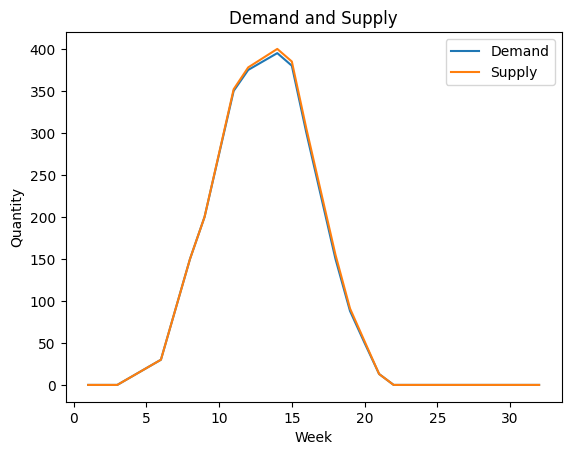

In [9]:
def visualize_demand_and_supply(demand, productionScheme, productionCurve):
    weeks = list(demand.keys())
    demand_values = list(demand.values())
    supply_values = [sum([cuttings * productionCurve.get(week - plant_week + 1 - firstHarvestWeek, 0) / 100 * maxPiecesPerHarvest for plant_week, cuttings in productionScheme if plant_week <= week]) for week in weeks]

    plt.plot(weeks, demand_values, label='Demand')
    plt.plot(weeks, supply_values, label='Supply')
    plt.xlabel('Week')
    plt.ylabel('Quantity')
    plt.title('Demand and Supply')
    plt.legend()
    plt.show()

visualize_demand_and_supply(demand, productionScheme, productionCurve)